In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pydicom

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from imblearn.over_sampling import RandomOverSampler
import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from helpers import get_ddsm_table, get_INBreast_table, get_VinDR_table, mask_image, run_intensity_functions, run_glcm_features, get_master_df

load = True
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

<h3>Load and Process Data</h3>

In [2]:
ddsm_df = get_ddsm_table()
INbreast_df = get_INBreast_table()
vindr_df = get_VinDR_table()

In [3]:
master_df = get_master_df(vindr_df, ddsm_df, INbreast_df)

In [ ]:
df_data = []
for i in tqdm(range(len(master_df))):
    row = master_df.iloc[i]
    image_stats = {
        "file_name": row['full_path'],
        "vendor": row['Manufacturer'],
        "laterality": row['laterality'], 
        "view_position": row['view_position'],
        "breast_density": row['breast_density']    
    }
    pixel_array = pydicom.dcmread(row['full_path']).pixel_array
    breast_tissue_image = mask_image(pixel_array)
    intensity_stats, hist_features = run_intensity_functions(breast_tissue_image)
    image_stats.update(intensity_stats)
    image_stats.update(hist_features)
    glcm_stats = run_glcm_features(breast_tissue_image)
    image_stats.update(glcm_stats)
    df_data.append(image_stats)

image_stats_df = pd.DataFrame(df_data)
image_stats_df.to_csv('complete_stats.csv', index=False)

100%|██████████| 2885/2885 [45:35<00:00,  1.05it/s]


In [10]:
if(load):
    image_stats_df = pd.read_csv('complete_stats.csv')

In [11]:
image_stats_df.head()

,file_name,vendor,laterality,view_position,breast_density,mean,max,min,std,median,skew,kurtosis,area_under_histogram,hist_1,bin_1,hist_2,bin_2,hist_3,bin_3,hist_4,bin_4,hist_5,bin_5,hist_6,bin_6,hist_7,bin_7,hist_8,bin_8,hist_9,bin_9,hist_10,bin_10,hist_11,bin_11,hist_12,bin_12,hist_13,bin_13,hist_14,bin_14,hist_15,bin_15,hist_16,bin_16,homogeneity_1,correlation_1,contrast_1,dissimilarity_1,ASM_1,energy_1,homogeneity_2,correlation_2,contrast_2,dissimilarity_2,ASM_2,energy_2,homogeneity_3,correlation_3,contrast_3,dissimilarity_3,ASM_3,energy_3
0,./VinDr/8269f5971eaca3e5d3772d1796e6bd7a/dd9ce...,SIEMENS,L,CC,DENSITY C,1368.850956,2279.0,40.0,296.508167,1377.0,-0.669633,0.871635,1857693.5,644,40.0,3322,179.9375,8546,319.875,20566,459.8125,38155,599.75,63026,739.6875,96170,879.625,114950,1019.5625,252957,1159.5,527965,1299.4375,284133,1439.375,266435,1579.3125,122681,1719.25,48338,1859.1875,9694,1999.125,867,2139.0625,0.116832,0.885412,240.804556,10.001721,0.000324,0.017999,0.059435,0.559002,838.794271,21.236752,0.000184,0.013550,0.042107,0.206805,1560.824828,30.075758,0.000124,0.011143
1,./VinDr/8269f5971eaca3e5d3772d1796e6bd7a/57fbd...,SIEMENS,L,MLO,DENSITY C,1375.314225,2471.0,136.0,325.002430,1371.0,-0.280620,-0.185908,2877825.0,508,136.0,8446,281.9375,22511,427.875,49054,573.8125,120670,719.75,204740,865.6875,265142,1011.625,483837,1157.5625,546344,1303.5,369696,1449.4375,397608,1595.375,299002,1741.3125,82354,1887.25,25157,2033.1875,2878,2179.125,264,2325.0625,0.115686,0.905141,219.162959,9.915999,0.000241,0.015510,0.050564,0.594511,845.056697,22.058684,0.000118,0.010842,0.029847,0.199568,1721.727970,32.991758,0.000086,0.009300
2,./VinDr/8269f5971eaca3e5d3772d1796e6bd7a/202d7...,SIEMENS,R,CC,DENSITY C,1392.739863,2253.0,154.0,279.631610,1408.0,-0.666178,1.098404,1958643.5,2805,154.0,5323,285.1875,8770,416.375,15861,547.5625,37150,678.75,79372,809.9375,108144,941.125,118806,1072.3125,256393,1203.5,578675,1334.6875,331035,1465.875,223277,1597.0625,123835,1728.25,58565,1859.4375,11736,1990.625,598,2121.8125,0.116013,0.914205,182.772774,9.540125,0.000325,0.018016,0.062658,0.644613,691.925928,19.425265,0.000201,0.014175,0.045695,0.312600,1364.466647,27.463823,0.000144,0.012020
3,./VinDr/8269f5971eaca3e5d3772d1796e6bd7a/acccc...,SIEMENS,R,MLO,DENSITY C,1382.998242,2405.0,107.0,338.190243,1393.0,-0.377883,-0.133439,2986444.5,724,107.0,9284,250.6250,23788,394.250,48709,537.8750,108630,681.50,192421,825.1250,217163,968.750,352755,1112.3750,563058,1256.0,467096,1399.6250,378759,1543.250,381630,1686.8750,181485,1830.50,51734,1974.1250,9319,2117.750,503,2261.3750,0.108879,0.921803,202.709961,10.004749,0.000209,0.014451,0.047203,0.624451,860.477697,22.565518,0.000107,0.010330,0.030446,0.212116,1852.714489,33.654888,0.000080,0.008951
4,./VinDr/ac4975eb788af8b7e15cafca9ac9a1c9/50098...,SIEMENS,L,CC,DENSITY C,1464.856269,2119.0,318.0,201.810213,1498.0,-0.973012,1.907731,974827.5,195,318.0,1965,430.5625,2030,543.125,3307,655.6875,4683,768.25,7156,880.8125,25975,993.375,60804,1105.9375,127642,1218.5,153283,1331.0625,227385,1443.625,227098,1556.1875,114862,1668.75,17175,1781.3125,1309,1893.875,112,2006.4375,0.102992,0.822202,259.976383,10.859118,0.000275,0.016590,0.057754,0.474452,728.938031,19.763763,0.000177,0.013296,0.045378,0.217697,1057.424930,24.285813,0.000159,0.012595


<h3>Run TSNE analysis</h3>

In [10]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
def run_tsne(features, labels):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(labels)
    tsne_results = tsne.fit_transform(features_scaled)
    tsne_df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
    tsne_df['Label'] = label_encoder.inverse_transform(numeric_labels)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Label", palette='Set1', s=100, alpha=0.7)
    plt.title("t-SNE of Image Features with Labels")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Classes")
    plt.show()

    return tsne_df

<h4>TSNE with all 60 Features</h4>

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


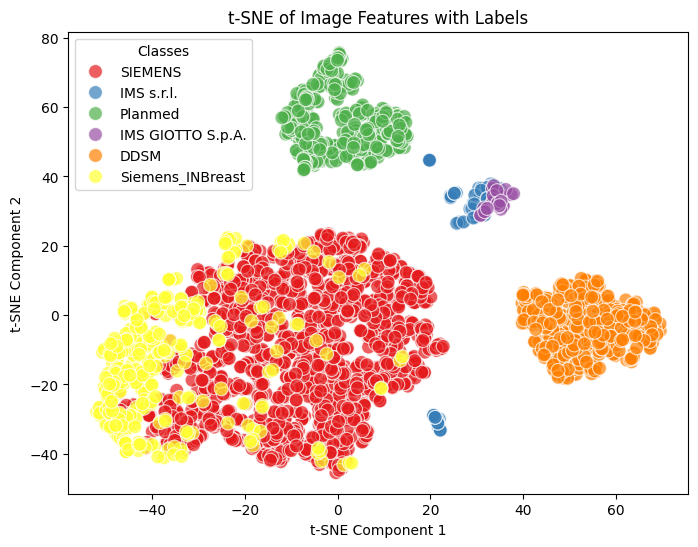

In [25]:
feature_set = image_stats_df.iloc[:,5:]
features = np.array(feature_set)
labels = image_stats_df['vendor'].values
results = run_tsne(features, labels)

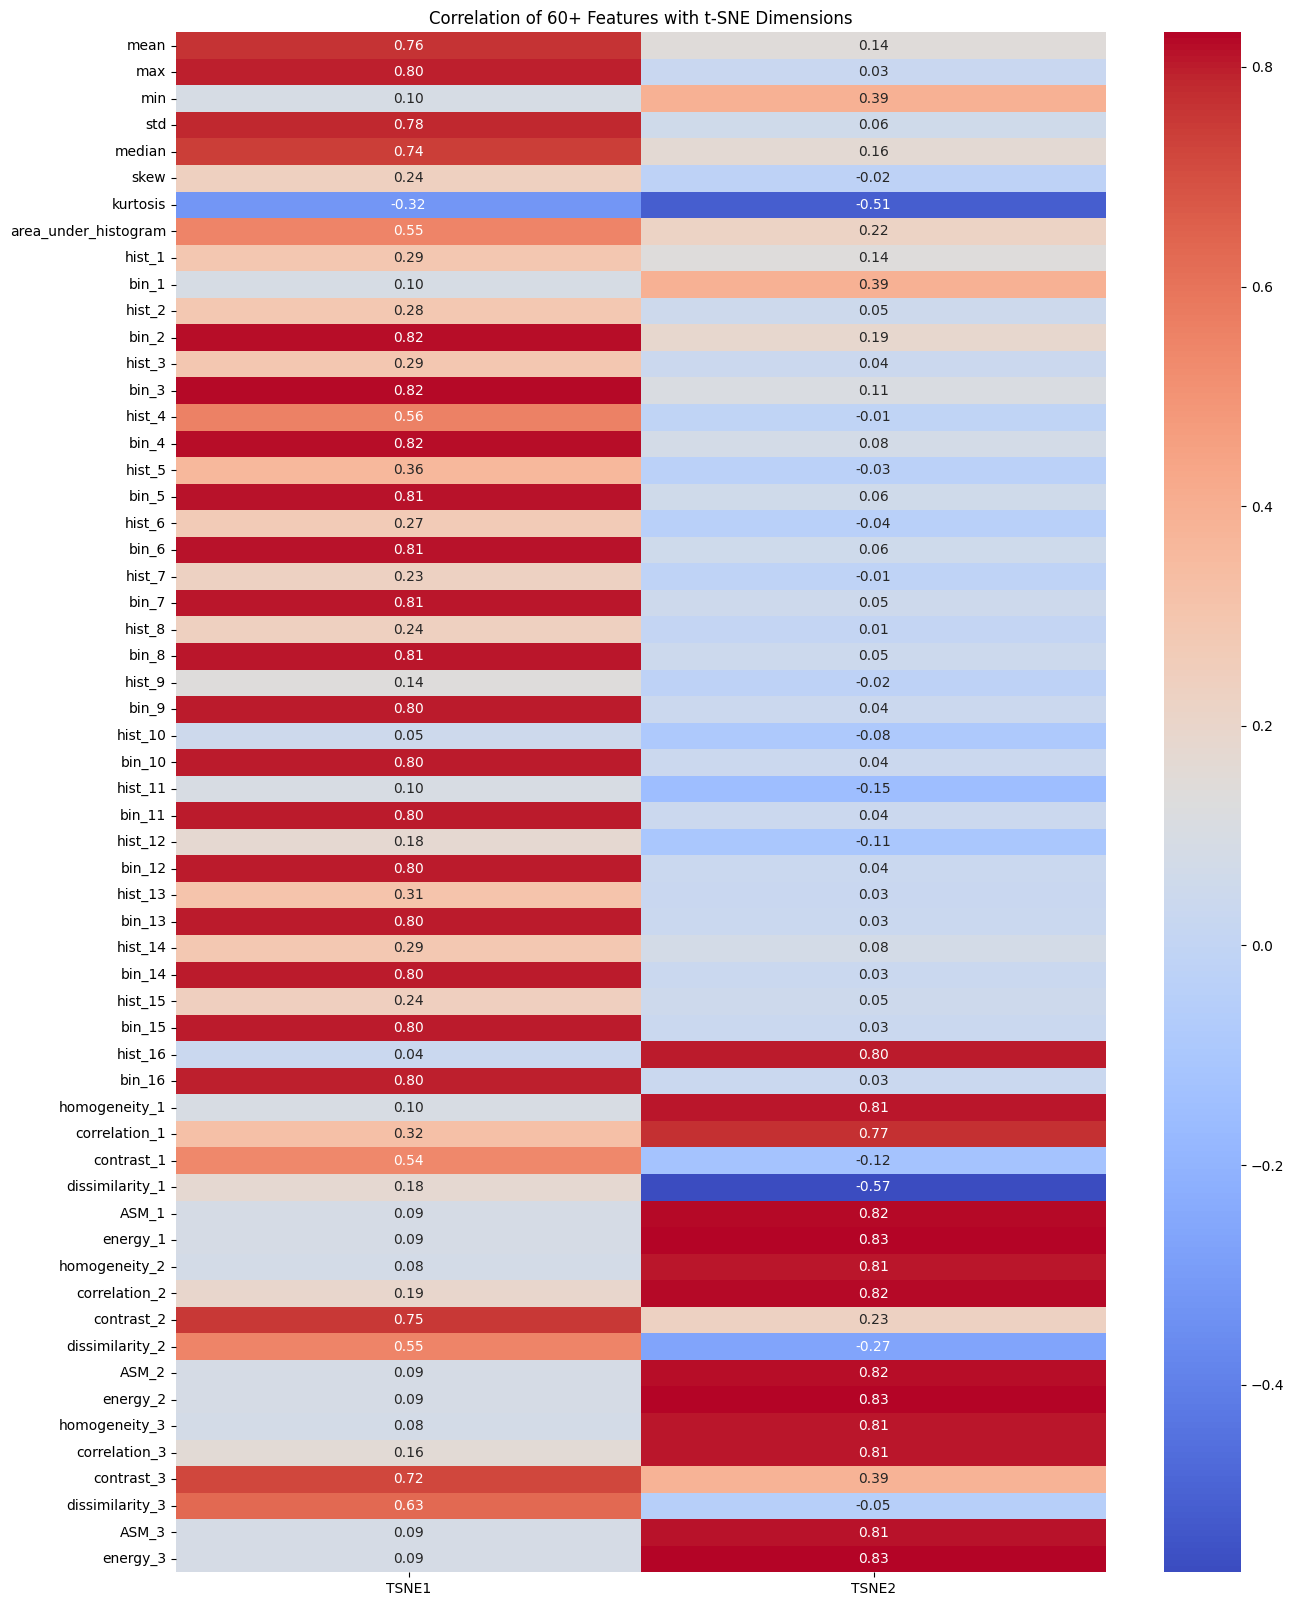

In [18]:
correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
plt.figure(figsize=(15, 20))
sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of 60+ Features with t-SNE Dimensions")
plt.show()

<h4>TSNE without the histogram features</h4>

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


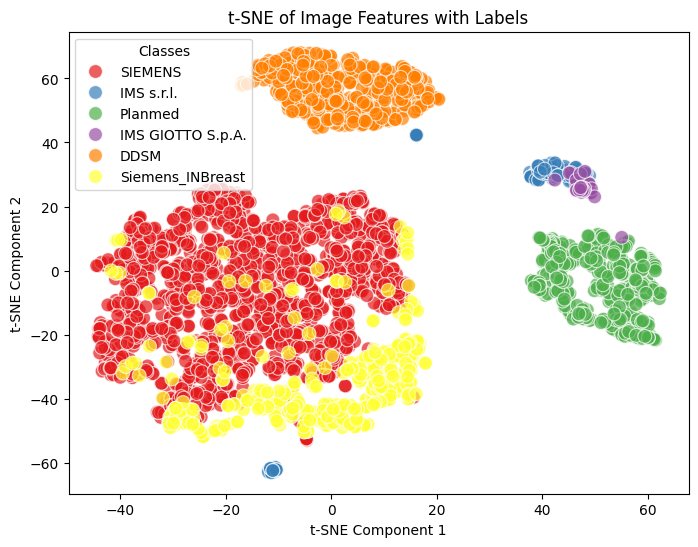

In [20]:
hist_features = ['hist_'+str(i+1) for i in range(16)]
bin_features = ['bin_'+str(i+1) for i in range(16)]
features_to_keep = image_stats_df.drop(columns=hist_features+bin_features)
feature_set = features_to_keep.iloc[:,5:]
features = np.array(feature_set)
labels = image_stats_df['vendor'].values
results = run_tsne(features, labels)

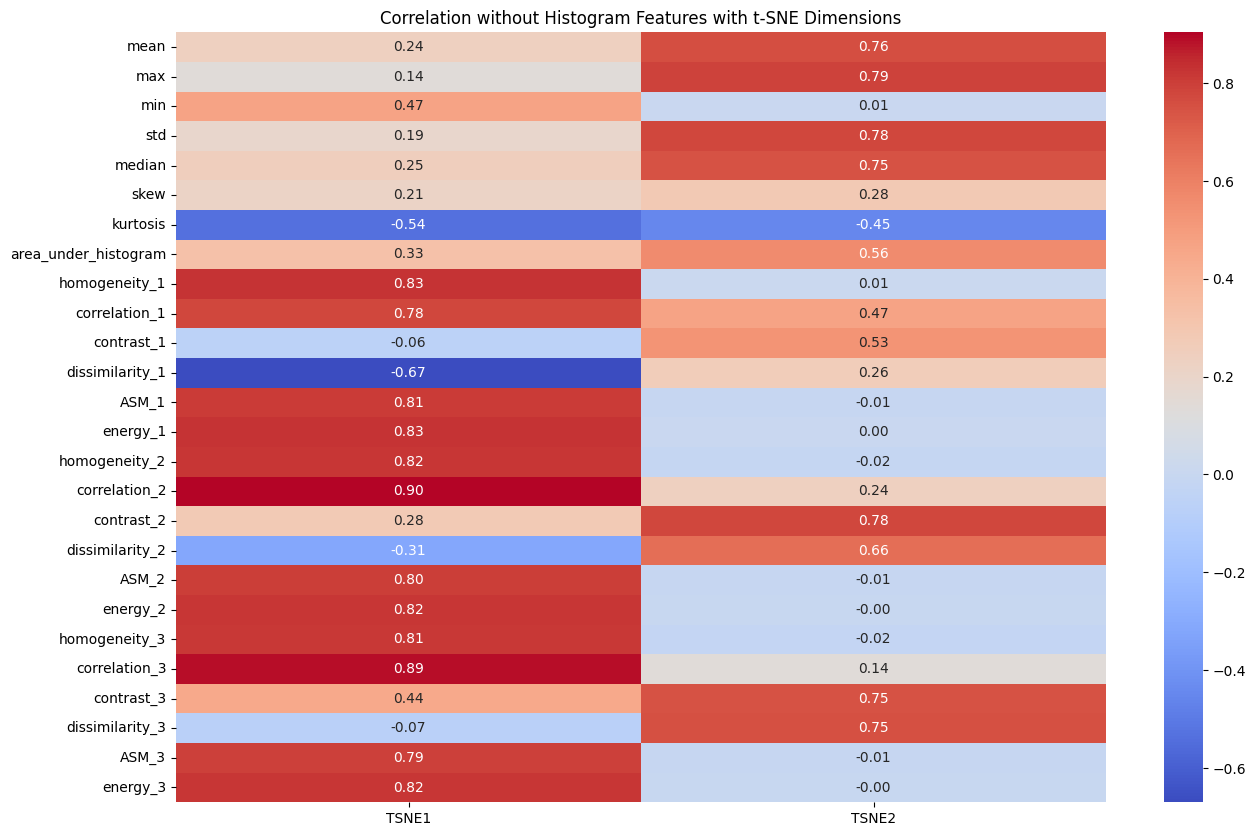

In [22]:
correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
plt.figure(figsize=(15, 10))
sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation without Histogram Features with t-SNE Dimensions")
plt.show()

<h4>TSNE with only minimum features</h4>

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


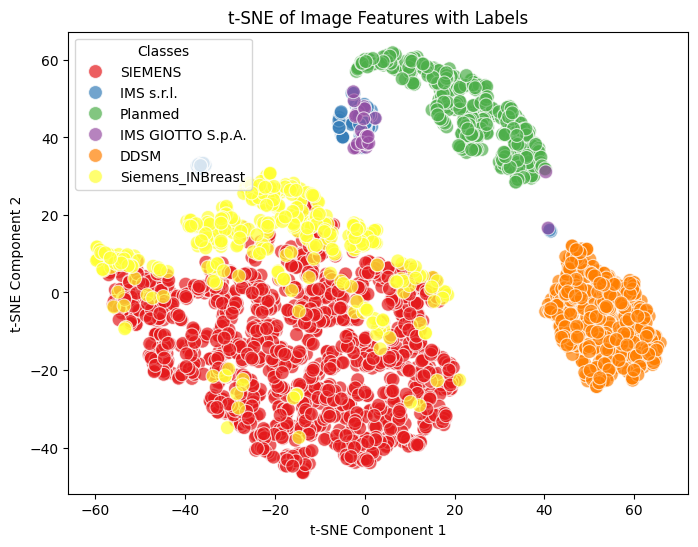

In [23]:
min_features = ['mean', 'std', 'kurtosis', 'area_under_histogram', 'homogeneity_1', 'correlation_2', 'contrast_2', 'dissimilarity_3', 'ASM_2']
feature_set = image_stats_df[min_features]
features = np.array(feature_set)
labels = image_stats_df['vendor'].values
results = run_tsne(features, labels)

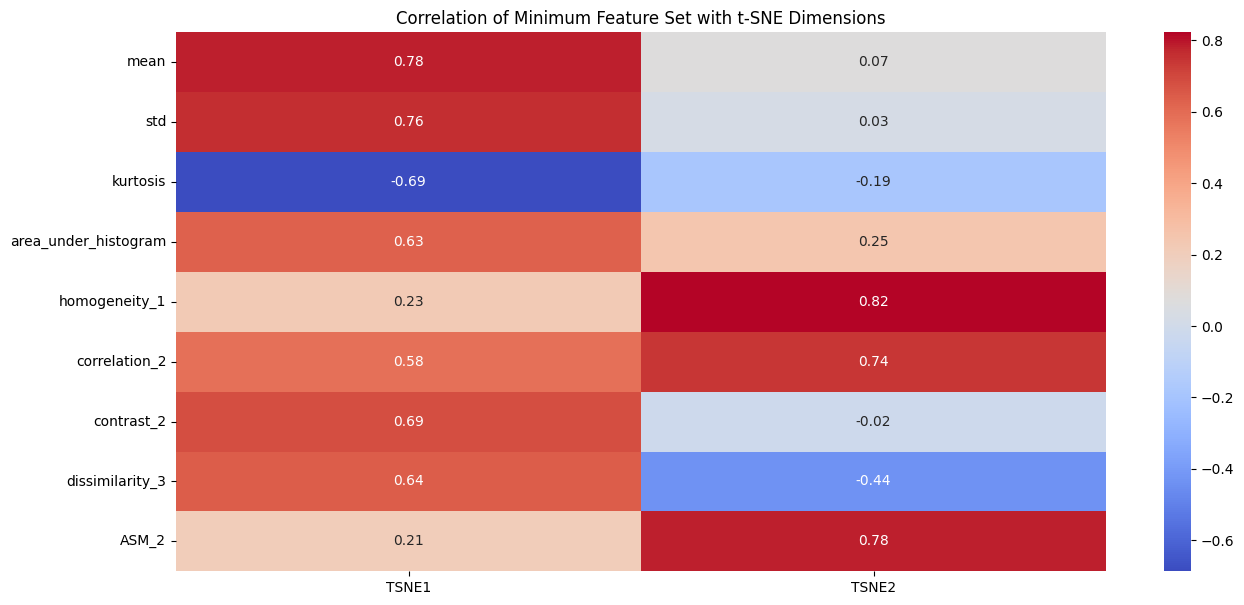

In [24]:
correlations = pd.concat([feature_set, results.iloc[:,:2]], axis=1).corr()
tsne_corr = correlations.loc[feature_set.columns, results.iloc[:,:2].columns]
plt.figure(figsize=(15, 7))
sns.heatmap(tsne_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Minimum Feature Set with t-SNE Dimensions")
plt.show()

<h3>NN Classifier for Class Prediction</h3>

In [2]:
if(load):
    image_stats_df = pd.read_csv('complete_stats.csv')

In [3]:
df = image_stats_df[['mean', 'std', 'kurtosis', 'area_under_histogram', 'homogeneity_1', 'correlation_2', 'contrast_2', 'dissimilarity_3', 'ASM_2', 'vendor']].copy()

In [ ]:
# df['vendor'] = df['vendor'].replace(['IMS s.r.l.', 'IMS GIOTTO S.p.A.'], 'IMS')
# df['vendor'] = df['vendor'].replace('Siemens_INBreast', 'SIEMENS')

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns='vendor'))
le = LabelEncoder()
y = le.fit_transform(df['vendor'])
# ros = RandomOverSampler(random_state=42)
# X_balanced, y_balanced = ros.fit_resample(X, y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [7]:
input_size = X_train.shape[1]
num_classes = len(np.unique(y))

In [8]:
model = nn.Sequential(
    nn.Linear(input_size, 32),  # Input to first hidden layer
    # nn.ReLU(),
    nn.Dropout(0.3),
    # nn.Linear(128, 64),          # First to second hidden layer
    nn.ReLU(),
    nn.Linear(32, num_classes)   # Second hidden layer to output
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
train_metrics = {"loss": [], "accuracy": [], "f1": [], "precision": [], "recall": []}
test_metrics = {"loss": [], "accuracy": [], "f1": [], "precision": [], "recall": []}

In [11]:
patience = 5
min_delta = 0.001
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

In [12]:
for epoch in tqdm(range(200)):  # Set maximum epochs
    if early_stop:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Training phase
    model.train()
    running_loss = 0.0
    y_true_train, y_pred_train = [], []

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    # Calculate training metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = accuracy_score(y_true_train, y_pred_train)
    epoch_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    epoch_precision = precision_score(y_true_train, y_pred_train, average='weighted')
    epoch_recall = recall_score(y_true_train, y_pred_train, average='weighted')

    train_metrics["loss"].append(epoch_loss)
    train_metrics["accuracy"].append(epoch_accuracy)
    train_metrics["f1"].append(epoch_f1)
    train_metrics["precision"].append(epoch_precision)
    train_metrics["recall"].append(epoch_recall)

    # Early stopping check
    if best_loss - epoch_loss > min_delta:
        best_loss = epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

  0%|          | 0/200 [00:00<?, ?it/s]/Users/taha/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  1%|          | 2/200 [00:00<00:12, 15.85it/s]/Users/taha/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/taha/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Early stopping at epoch 46


In [13]:
# Evaluation Loop
model.eval()
running_loss = 0.0
y_true_test, y_pred_test = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())

# Calculate metrics for test set
test_loss = running_loss / len(test_loader)
test_accuracy = accuracy_score(y_true_test, y_pred_test)
test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')
test_precision = precision_score(y_true_test, y_pred_test, average='weighted')
test_recall = recall_score(y_true_test, y_pred_test, average='weighted')

test_metrics["loss"].append(test_loss)
test_metrics["accuracy"].append(test_accuracy)
test_metrics["f1"].append(test_f1)
test_metrics["precision"].append(test_precision)
test_metrics["recall"].append(test_recall)

print(f"Test Metrics - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

Test Metrics - Loss: 0.1567, Accuracy: 0.9434, F1: 0.9396, Precision: 0.9412, Recall: 0.9434


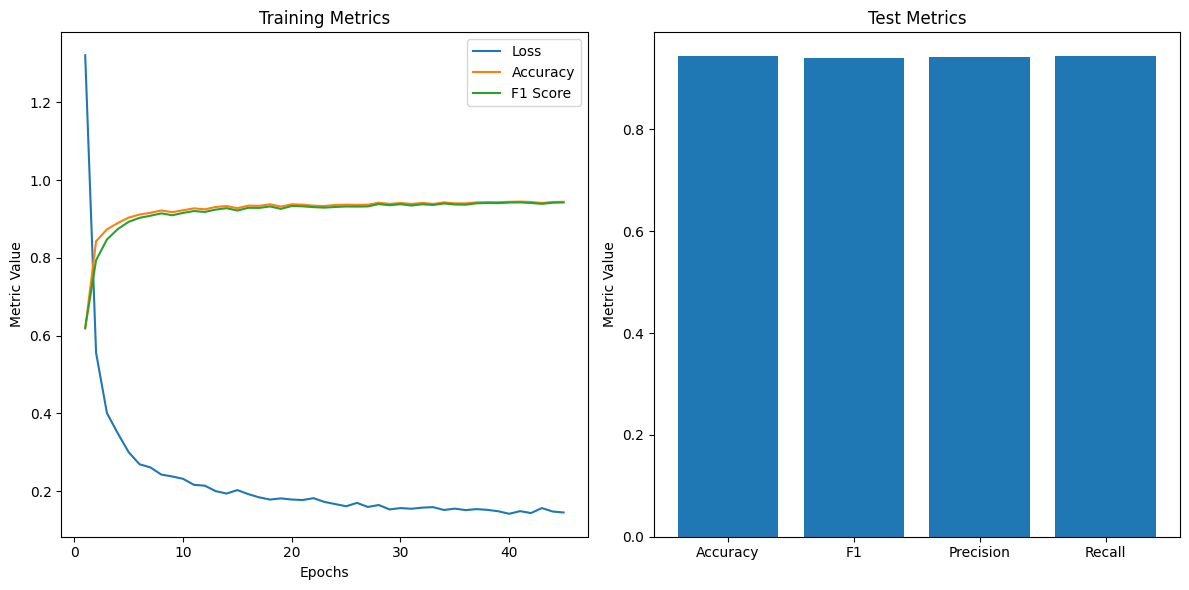

In [14]:
epochs = range(1, len(train_metrics["loss"]) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_metrics["loss"], label="Loss")
plt.plot(epochs, train_metrics["accuracy"], label="Accuracy")
plt.plot(epochs, train_metrics["f1"], label="F1 Score")
plt.title("Training Metrics")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.legend()

# Plot test metrics
plt.subplot(1, 2, 2)
plt.bar(["Accuracy", "F1", "Precision", "Recall"], 
        [test_metrics["accuracy"][0], test_metrics["f1"][0], test_metrics["precision"][0], test_metrics["recall"][0]])
plt.title("Test Metrics")
plt.ylabel("Metric Value")

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

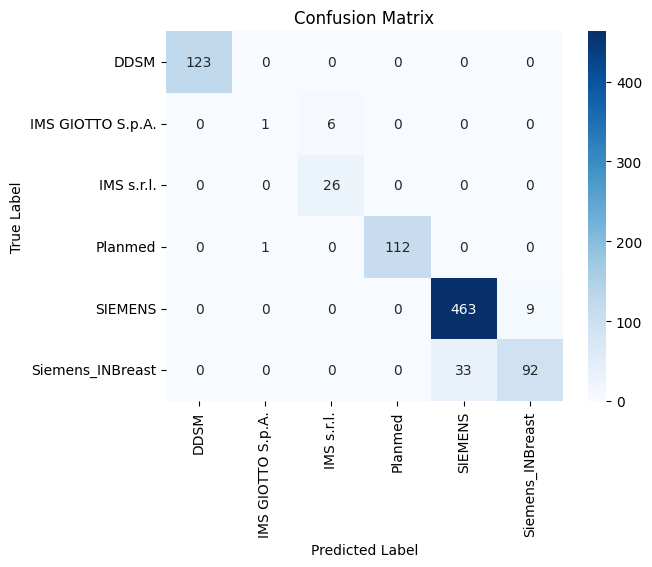

                   precision    recall  f1-score   support

             DDSM       1.00      1.00      1.00       123
IMS GIOTTO S.p.A.       0.50      0.14      0.22         7
       IMS s.r.l.       0.81      1.00      0.90        26
          Planmed       1.00      0.99      1.00       113
          SIEMENS       0.93      0.98      0.96       472
 Siemens_INBreast       0.91      0.74      0.81       125

         accuracy                           0.94       866
        macro avg       0.86      0.81      0.81       866
     weighted avg       0.94      0.94      0.94       866



In [16]:
model.eval()
y_true_test, y_pred_test = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true_test, y_pred_test, target_names=le.classes_))